**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on January 3rd, 2021

In [23]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm
import tables

In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

## Set up the StatsBombLoader

In [3]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = StatsBombLoader(root=free_open_data_remote, getter="remote")

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
# datafolder = "../data/statsbomb-epl-1718" # Example of local folder with statsbomb data
# SBL = StatsBombLoader(root=datafolder, getter="local")

## Select competitions to load and convert

In [4]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "Women's World Cup"}

In [14]:
# Fifa world cup
competition_names = ["Champions League", "FIFA World Cup", "La Liga", "Premier League", "UEFA Euro"]
season_ids = [3, 90, 42, 4, 1, 2, 27, 26, 25, 24, 23, 22, 43]
selected_competitions = competitions[
    (competitions.competition_name.isin(competition_names)) &
    (competitions.season_id.isin(season_ids))
]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,4,16,Champions League,Europe,male,2018/2019
1,1,16,Champions League,Europe,male,2017/2018
2,2,16,Champions League,Europe,male,2016/2017
3,27,16,Champions League,Europe,male,2015/2016
4,26,16,Champions League,Europe,male,2014/2015
5,25,16,Champions League,Europe,male,2013/2014
6,24,16,Champions League,Europe,male,2012/2013
7,23,16,Champions League,Europe,male,2011/2012
8,22,16,Champions League,Europe,male,2010/2011
18,3,43,FIFA World Cup,International,male,2018


In [16]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
]).reset_index(drop=True)
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,38,24,2019-06-01 21:00:00,0,2
1,220,24,2018-05-26 20:45:00,3,1
2,224,220,2017-06-03 20:45:00,1,4
3,220,212,2016-05-28 20:45:00,1,1
4,224,217,2015-06-06 20:45:00,1,3
...,...,...,...,...,...
495,776,1835,2021-06-12 18:00:00,0,1
496,908,772,2021-06-23 18:00:00,0,5
497,790,789,2021-06-23 18:00:00,3,2
498,782,796,2021-06-12 21:00:00,3,0


## Load and convert match data

In [17]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|█████████████████████████████████████████████████████████| 500/500 [21:40<00:00,  2.60s/it]


## Store converted SPADL data in a h5-file

In [25]:
datafolder = "../data-spadl"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

## Plot the SPADL data
Extra library required: ```pip install matplotsoccer```

In [26]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:10]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,8657,a7ec7898-799e-4e79-bc54-54d4cba812cf,1,0.0,782,3289,52.941176,33.569620,44.117647,33.569620,0,1,0,0,pass,success,foot,Romelu Lukaku,Belgium
1,8657,f6046ebb-23b5-4ca2-ad94-f6428e1dd073,1,1.0,782,5642,44.117647,33.569620,44.117647,34.430380,21,1,0,1,dribble,success,foot,Axel Witsel,Belgium
2,8657,ff0b59e3-4c63-48cf-a81d-024dd69e1c95,1,2.0,782,5642,44.117647,34.430380,31.764706,53.367089,0,1,0,2,pass,success,foot,Axel Witsel,Belgium
3,8657,6133b1ef-1489-4851-9eef-b1d66f898461,1,3.0,782,3077,31.764706,53.367089,28.235294,53.367089,21,1,0,3,dribble,success,foot,Jan Vertonghen,Belgium
4,8657,9c0d9486-4c63-4d5d-bb31-4e2a06c5a486,1,4.0,782,3077,28.235294,53.367089,23.823529,38.734177,0,1,0,4,pass,success,foot,Jan Vertonghen,Belgium
5,8657,ed0782aa-3d66-4350-a8ba-870e06c32cd5,1,6.0,782,3101,23.823529,38.734177,17.647059,30.987342,21,1,0,5,dribble,success,foot,Vincent Kompany,Belgium
6,8657,62603e53-a55c-452f-b9c4-14d5ac2856b5,1,7.0,782,3101,17.647059,30.987342,18.529412,6.025316,0,1,0,6,pass,success,foot,Vincent Kompany,Belgium
7,8657,b0a452ac-8e41-4388-a5d4-b72cfd999bca,1,9.0,782,20005,18.529412,6.025316,43.235294,3.443038,21,1,0,7,dribble,success,foot,Toby Alderweireld,Belgium
8,8657,f1b89485-6c03-40d7-a594-125f1d81e237,1,15.0,782,20005,43.235294,3.443038,48.529412,1.721519,0,1,0,8,pass,success,foot,Toby Alderweireld,Belgium
9,8657,c46594ca-9778-41df-81f3-fb5267260e28,1,16.0,782,3176,48.529412,1.721519,47.647059,1.721519,21,1,0,9,dribble,success,foot,Thomas Meunier,Belgium


2018-07-14 16:00:00 Belgium 2-0 England 82'


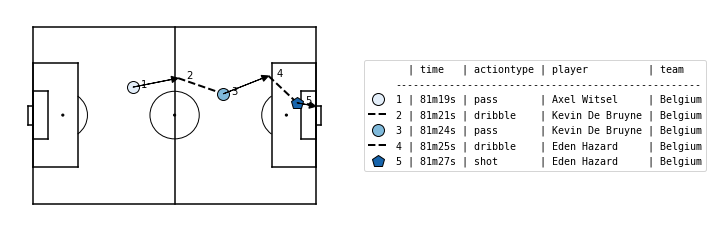

In [27]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
shot = 2201
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)